In [1]:
import pandas as pd
import numpy as np
import sqlite3
from pprint import pprint
import folium
from folium import plugins
from folium.plugins import HeatMap
%matplotlib inline
import matplotlib
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import pygeohash as pgh
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plot_options = dict(figsize=(12,6))

In [2]:
conn = sqlite3.connect("FPA_FOD_20170508.sqlite")

In [3]:
cursor = conn.cursor()
# get tables
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
pprint(cursor.fetchall())

[('spatial_ref_sys',),
 ('spatialite_history',),
 ('sqlite_sequence',),
 ('geometry_columns',),
 ('spatial_ref_sys_aux',),
 ('views_geometry_columns',),
 ('virts_geometry_columns',),
 ('geometry_columns_statistics',),
 ('views_geometry_columns_statistics',),
 ('virts_geometry_columns_statistics',),
 ('geometry_columns_field_infos',),
 ('views_geometry_columns_field_infos',),
 ('virts_geometry_columns_field_infos',),
 ('geometry_columns_time',),
 ('geometry_columns_auth',),
 ('views_geometry_columns_auth',),
 ('virts_geometry_columns_auth',),
 ('sql_statements_log',),
 ('SpatialIndex',),
 ('ElementaryGeometries',),
 ('KNN',),
 ('Fires',),
 ('idx_Fires_Shape',),
 ('idx_Fires_Shape_node',),
 ('idx_Fires_Shape_rowid',),
 ('idx_Fires_Shape_parent',),
 ('NWCG_UnitIDActive_20170109',)]


In [4]:
cursor.execute("SELECT MAX(FOD_ID) FROM Fires")
print(cursor.fetchall())

[(300348399,)]


In [5]:
cursor.execute("SELECT MAX(OBJECTID) FROM Fires")
print(cursor.fetchall())

[(1880465,)]


In [6]:
cursor.execute("SELECT DISTINCT(STAT_CAUSE_CODE) FROM Fires")
print(cursor.fetchall())

[(9.0,), (1.0,), (5.0,), (4.0,), (2.0,), (7.0,), (8.0,), (6.0,), (3.0,), (11.0,), (12.0,), (10.0,), (13.0,)]


In [7]:
cursor.execute("SELECT DISTINCT(STAT_CAUSE_DESCR) FROM Fires")
print(cursor.fetchall())

[('Miscellaneous',), ('Lightning',), ('Debris Burning',), ('Campfire',), ('Equipment Use',), ('Arson',), ('Children',), ('Railroad',), ('Smoking',), ('Powerline',), ('Structure',), ('Fireworks',), ('Missing/Undefined',)]


In [8]:
df = pd.read_sql_query("SELECT * FROM Fires LIMIT 5;", conn)
df

,OBJECTID,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,...,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME,Shape
0,1,1,FS-1418826,FED,FS-FIRESTAT,FS,USCAPNF,Plumas National Forest,0511,Plumas National Forest,...,A,40.036944,-121.005833,5.0,USFS,CA,63,063,Plumas,b'\x00\x01\xad\x10\x00\x00\xe8d\xc2\x92_@^\xc0...
1,2,2,FS-1418827,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.933056,-120.404444,5.0,USFS,CA,61,061,Placer,b'\x00\x01\xad\x10\x00\x00T\xb6\xeej\xe2\x19^\...
2,3,3,FS-1418835,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.984167,-120.735556,13.0,STATE OR PRIVATE,CA,17,017,El Dorado,b'\x00\x01\xad\x10\x00\x00\xd0\xa5\xa0W\x13/^\...
3,4,4,FS-1418845,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.559167,-119.913333,5.0,USFS,CA,3,003,Alpine,b'\x00\x01\xad\x10\x00\x00\x94\xac\xa3\rt\xfa]...
4,5,5,FS-1418847,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.559167,-119.933056,5.0,USFS,CA,3,003,Alpine,b'\x00\x01\xad\x10\x00\x00@\xe3\xaa.\xb7\xfb]\...


In [9]:
pprint(list(df.columns))

['OBJECTID',
 'FOD_ID',
 'FPA_ID',
 'SOURCE_SYSTEM_TYPE',
 'SOURCE_SYSTEM',
 'NWCG_REPORTING_AGENCY',
 'NWCG_REPORTING_UNIT_ID',
 'NWCG_REPORTING_UNIT_NAME',
 'SOURCE_REPORTING_UNIT',
 'SOURCE_REPORTING_UNIT_NAME',
 'LOCAL_FIRE_REPORT_ID',
 'LOCAL_INCIDENT_ID',
 'FIRE_CODE',
 'FIRE_NAME',
 'ICS_209_INCIDENT_NUMBER',
 'ICS_209_NAME',
 'MTBS_ID',
 'MTBS_FIRE_NAME',
 'COMPLEX_NAME',
 'FIRE_YEAR',
 'DISCOVERY_DATE',
 'DISCOVERY_DOY',
 'DISCOVERY_TIME',
 'STAT_CAUSE_CODE',
 'STAT_CAUSE_DESCR',
 'CONT_DATE',
 'CONT_DOY',
 'CONT_TIME',
 'FIRE_SIZE',
 'FIRE_SIZE_CLASS',
 'LATITUDE',
 'LONGITUDE',
 'OWNER_CODE',
 'OWNER_DESCR',
 'STATE',
 'COUNTY',
 'FIPS_CODE',
 'FIPS_NAME',
 'Shape']


In [10]:
df = pd.read_sql_query("SELECT * FROM NWCG_UnitIDActive_20170109 LIMIT 5;", conn)
df

,OBJECTID,UnitId,GeographicArea,Gacc,WildlandRole,UnitType,Department,Agency,Parent,Country,State,Code,Name
0,1,USAKCAN,AK,USAKACC,Resource Provider Only,Non-Government,NG,ANC,None,US,AK,CAN,Calista Regional Native Corporation
1,2,USAKCEKX,AK,USAKACC,Incident Host Geographic,US County/Local,AK,C&L,None,US,AK,CEKX,Central Emergency Services
2,3,USAKCFFX,AK,USAKACC,Incident Host Geographic,US County/Local,AK,C&L,None,US,AK,CFFX,City Fairbanks Fire Department
3,4,USAKCFMX,AK,USAKACC,Incident Host Geographic,US County/Local,AK,C&L,None,US,AK,CFMX,Central Mat-Su Fire Department
4,5,USAKCFQ,AK,USAKACC,Incident Host Geographic,US Federal,DOD,USAF,None,US,AK,CFQ,Clear Air Force Station


In [11]:
pprint(list(df.columns))

['OBJECTID',
 'UnitId',
 'GeographicArea',
 'Gacc',
 'WildlandRole',
 'UnitType',
 'Department',
 'Agency',
 'Parent',
 'Country',
 'State',
 'Code',
 'Name']


In [12]:
df = pd.read_sql_query("SELECT OBJECTID, LATITUDE, LONGITUDE, STAT_CAUSE_CODE, FIRE_SIZE, FIRE_YEAR FROM Fires;", conn)
df

,OBJECTID,LATITUDE,LONGITUDE,STAT_CAUSE_CODE,FIRE_SIZE,FIRE_YEAR
0,1,40.036944,-121.005833,9.0,0.10,2005
1,2,38.933056,-120.404444,1.0,0.25,2004
2,3,38.984167,-120.735556,5.0,0.10,2004
3,4,38.559167,-119.913333,1.0,0.10,2004
4,5,38.559167,-119.933056,1.0,0.10,2004
...,...,...,...,...,...,...
1880460,1880461,40.481637,-122.389375,13.0,0.01,2015
1880461,1880462,37.617619,-120.938570,9.0,0.20,2015
1880462,1880463,37.617619,-120.938570,13.0,0.10,2015
1880463,1880464,37.672235,-120.898356,13.0,2.00,2015


In [13]:
df.describe()

,OBJECTID,LATITUDE,LONGITUDE,STAT_CAUSE_CODE,FIRE_SIZE,FIRE_YEAR
count,1.880465e+06,1.880465e+06,1.880465e+06,1.880465e+06,1.880465e+06,1.880465e+06
mean,9.402330e+05,3.678121e+01,-9.570494e+01,5.979037e+00,7.452016e+01,2.003710e+03
std,5.428436e+05,6.139031e+00,1.671694e+01,3.483860e+00,2.497598e+03,6.663099e+00
min,1.000000e+00,1.793972e+01,-1.788026e+02,1.000000e+00,1.000000e-05,1.992000e+03
25%,4.701170e+05,3.281860e+01,-1.103635e+02,3.000000e+00,1.000000e-01,1.998000e+03
50%,9.402330e+05,3.545250e+01,-9.204304e+01,5.000000e+00,1.000000e+00,2.004000e+03
75%,1.410349e+06,4.082720e+01,-8.229760e+01,9.000000e+00,3.300000e+00,2.009000e+03
max,1.880465e+06,7.033060e+01,-6.525694e+01,1.300000e+01,6.069450e+05,2.015000e+03


In [14]:
df.dtypes

OBJECTID             int64
LATITUDE           float64
LONGITUDE          float64
STAT_CAUSE_CODE    float64
FIRE_SIZE          float64
FIRE_YEAR            int64
dtype: object

In [15]:
heat_df = df[["LATITUDE","LONGITUDE", "FIRE_YEAR", "FIRE_SIZE"]]
#heat_df = heat_df[heat_df["FIRE_YEAR"] == 1992]
heat_df = heat_df[heat_df["FIRE_SIZE"] > 1800]
heat_df = heat_df.dropna(axis=0, subset=["LATITUDE","LONGITUDE"])

# List comprehension to make out list of lists
heat_data = [[row["LATITUDE"],row["LONGITUDE"]] for index, row in heat_df.iterrows()]
print(heat_df.shape[0], " elements")
del heat_df

7666  elements


In [16]:
map_ = folium.Map(location=[df["LATITUDE"].mean(), df["LONGITUDE"].mean()],
                    tiles = "Stamen Terrain",                    
                    zoom_start = 3) 

# Plot it on the map
HeatMap(heat_data, min_opacity=.4, max_val=.8).add_to(map_)

# Display the map
map_

In [17]:
map_.save("figures/overall_fire-size-over-1800.html")

In [18]:
heat_time_df = df[["LATITUDE","LONGITUDE", "FIRE_YEAR", "FIRE_SIZE"]]
heat_time_df = heat_time_df[heat_time_df["FIRE_SIZE"] > 1500]
heat_time_df = heat_time_df.dropna(axis=0, subset=["LATITUDE","LONGITUDE"])

# List comprehension to make out list of lists
heat_time_data = [
    [
        [row['LATITUDE'],row['LONGITUDE']] for index, row in heat_time_df[heat_time_df["FIRE_YEAR"] == year].iterrows()
    ] for year in range(1992,2016)
]
print(heat_time_df.shape[0], " elements")
del heat_time_df

8504  elements


In [19]:
map_ = folium.Map(location=[df["LATITUDE"].mean()+3.3, df["LONGITUDE"].mean()-8.5],                  
                    tiles = "Stamen Terrain",
                    zoom_start = 4.5) 
# Plot it on the map
hm = plugins.HeatMapWithTime(
    heat_time_data,
    auto_play=True,
    max_opacity=0.6,
    name="HeatMap",
    index=list(range(1992,2016))
)
hm.add_to(map_)

map_

In [20]:
map_.save("figures/evolution_fire-size-over-1500.html")

In [21]:
df = pd.read_sql_query("SELECT SUM(FIRE_SIZE) AS SUM_FIRE_SIZE, State FROM Fires GROUP BY State;", conn)
df = df.set_index("STATE")
df[:5]

,SUM_FIRE_SIZE
STATE,
AK,3.223309e+07
AL,9.205453e+05
AR,5.089118e+05
AZ,5.576681e+06
CA,1.274586e+07


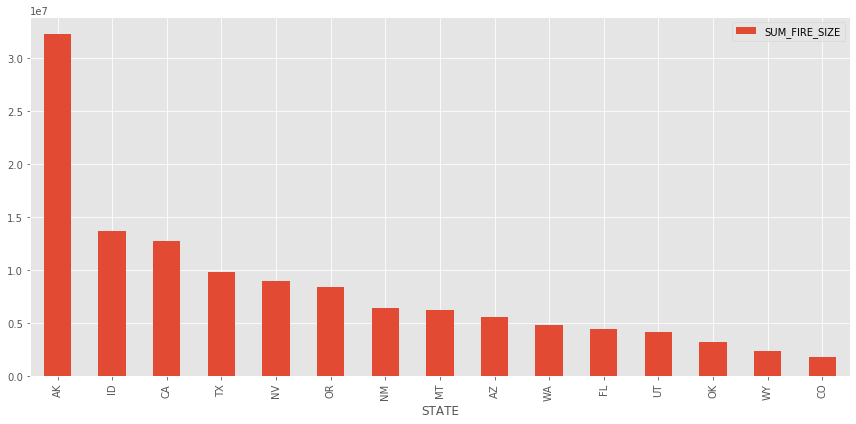

In [22]:
df.sort_values(by="SUM_FIRE_SIZE", ascending=False).iloc[:15].plot(kind="bar", **plot_options);
plt.tight_layout()
plt.savefig("figures/sum_fire_size_per_state.png")

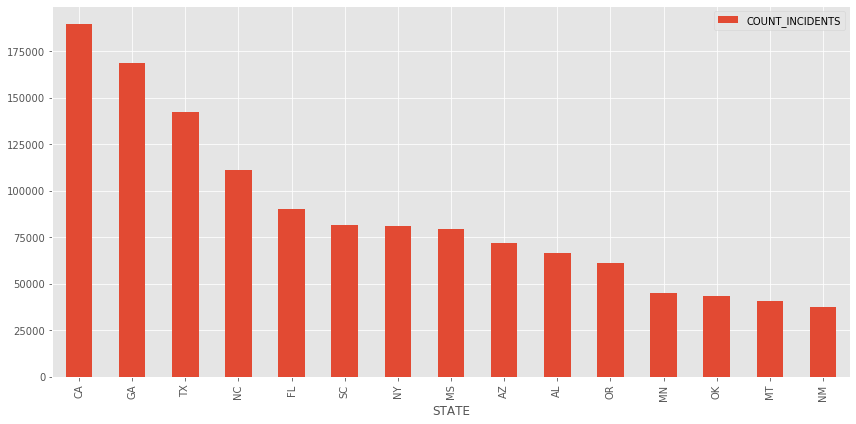

In [23]:
df = pd.read_sql_query("SELECT COUNT(OBJECTID) AS COUNT_INCIDENTS, State FROM Fires GROUP BY State;", conn)
df.set_index("STATE").sort_values(by="COUNT_INCIDENTS", ascending=False).iloc[:15].plot(kind="bar", **plot_options);
plt.tight_layout()
plt.savefig("figures/count_incidents_per_state.png")

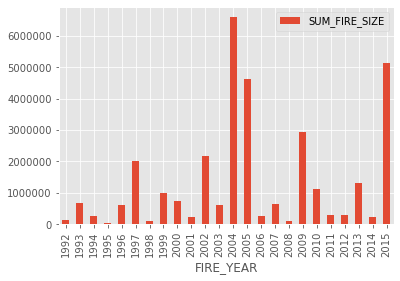

In [24]:
df = pd.read_sql_query("SELECT SUM(FIRE_SIZE) AS SUM_FIRE_SIZE, State, FIRE_YEAR FROM Fires WHERE State='AK' GROUP BY FIRE_YEAR;", conn)
df.set_index("FIRE_YEAR").plot(kind="bar");

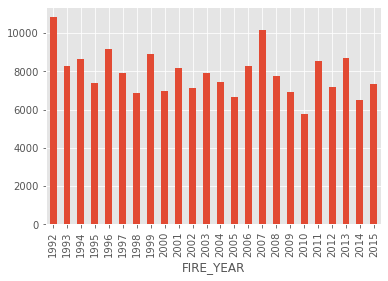

In [25]:
df = pd.read_sql_query("SELECT COUNT(OBJECTID) AS COUNT_INCIDENTS, State, FIRE_YEAR FROM Fires WHERE State='CA' GROUP BY FIRE_YEAR;", conn)
df.set_index("FIRE_YEAR")["COUNT_INCIDENTS"].plot(kind="bar");

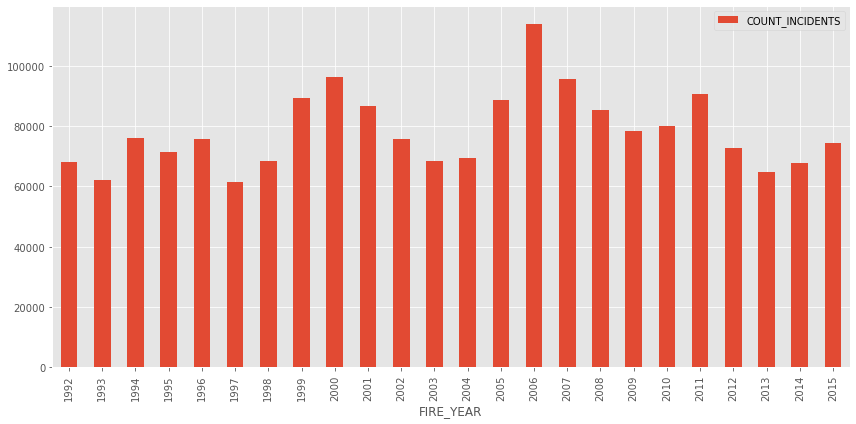

In [26]:
df = pd.read_sql_query("SELECT COUNT(OBJECTID) AS COUNT_INCIDENTS, FIRE_YEAR FROM Fires GROUP BY FIRE_YEAR;", conn)
df.set_index("FIRE_YEAR").plot(kind="bar", **plot_options);
#df.plot.scatter(x="FIRE_YEAR", y="COUNT_INCIDENTS");

plt.tight_layout()
plt.savefig("figures/count_incidents_over_years.png")

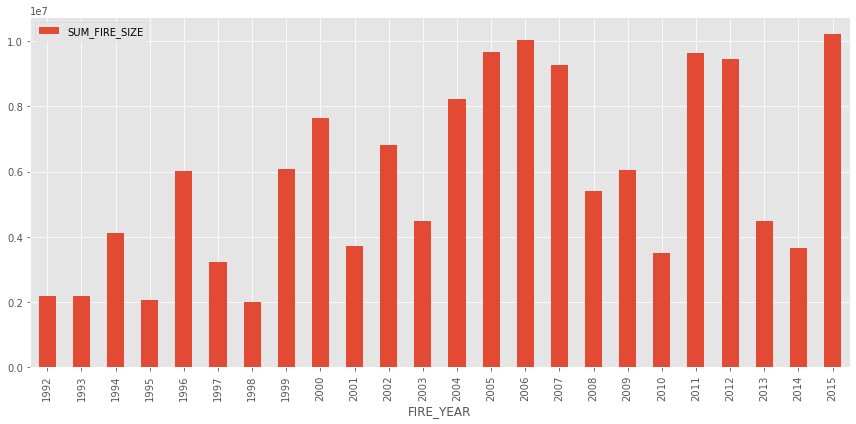

In [27]:
df = pd.read_sql_query("SELECT SUM(FIRE_SIZE) AS SUM_FIRE_SIZE, FIRE_YEAR FROM Fires GROUP BY FIRE_YEAR;", conn)
df.set_index("FIRE_YEAR").plot(kind="bar", **plot_options);
#df.plot.scatter(x="FIRE_YEAR", y="SUM_FIRE_SIZE");

plt.tight_layout()
plt.savefig("figures/sum_fire_size_over_years.png")

### Seasonal fluctuations over year

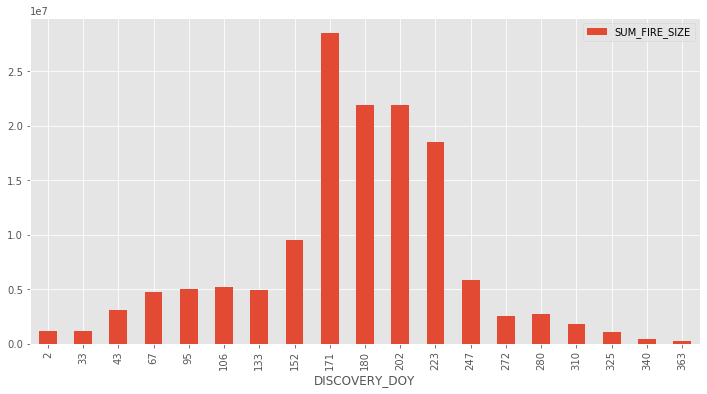

In [28]:
df = pd.read_sql_query("SELECT SUM(FIRE_SIZE) AS SUM_FIRE_SIZE, DISCOVERY_DOY FROM Fires GROUP BY DISCOVERY_DOY/20;", conn)

df.set_index("DISCOVERY_DOY").plot(kind="bar", **plot_options);

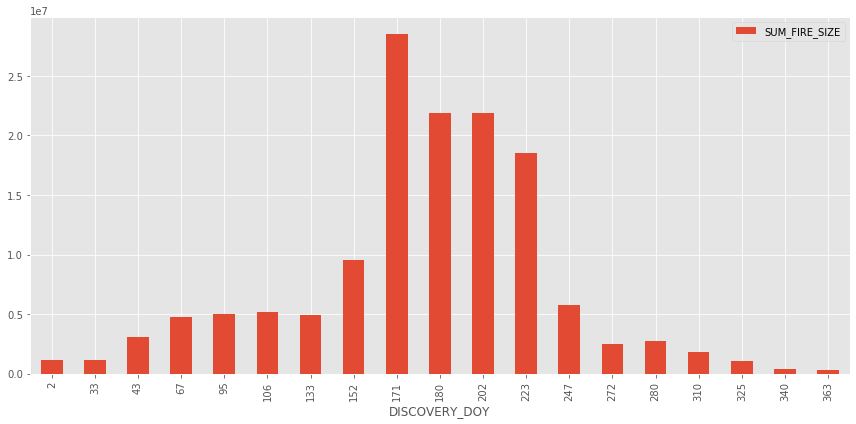

In [29]:
df = pd.read_sql_query("SELECT SUM(FIRE_SIZE) AS SUM_FIRE_SIZE, DISCOVERY_DOY FROM Fires GROUP BY DISCOVERY_DOY/20;", conn)
df.set_index("DISCOVERY_DOY").plot(kind="bar", **plot_options);

plt.tight_layout()
plt.savefig("figures/sum_fire_size_over_doy.png")

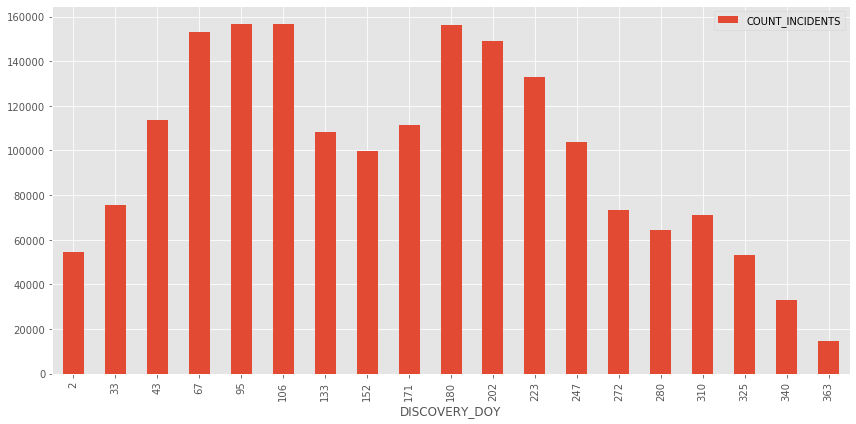

In [30]:
df = pd.read_sql_query("SELECT COUNT(OBJECTID) AS COUNT_INCIDENTS, DISCOVERY_DOY FROM Fires GROUP BY DISCOVERY_DOY/20;", conn)
df.set_index("DISCOVERY_DOY").plot(kind="bar", **plot_options);
plt.tight_layout()
plt.savefig("figures/count_incidents_over_doy.png")

#### mean time of a fire

In [31]:
df = pd.read_sql_query("SELECT DISCOVERY_DATE, CONT_DATE, (CONT_DATE-DISCOVERY_DATE) AS DURATION, DISCOVERY_DOY, CONT_DOY FROM Fires LIMIT 10;", conn)
df

,DISCOVERY_DATE,CONT_DATE,DURATION,DISCOVERY_DOY,CONT_DOY
0,2453403.5,2453403.5,0.0,33,33
1,2453137.5,2453137.5,0.0,133,133
2,2453156.5,2453156.5,0.0,152,152
3,2453184.5,2453189.5,5.0,180,185
4,2453184.5,2453189.5,5.0,180,185
5,2453186.5,2453187.5,1.0,182,183
6,2453187.5,2453188.5,1.0,183,184
7,2453437.5,2453437.5,0.0,67,67
8,2453444.5,2453444.5,0.0,74,74
9,2453187.5,2453188.5,1.0,183,184


In [32]:
df = pd.read_sql_query("""
SELECT COUNT(OBJECTID) AS COUNT_INCIDENTS, CAST((CONT_DATE-DISCOVERY_DATE) AS int)/(10*7) AS DURATION_IN_WEEKS FROM Fires 
WHERE DURATION_IN_WEEKS IS NOT NULL
GROUP BY DURATION_IN_WEEKS;
""", conn)
df

,COUNT_INCIDENTS,DURATION_IN_WEEKS
0,985387,0
1,2718,1
2,511,2
3,180,3
4,21,4
5,79,5
6,9,10
7,9,15
8,4,20
9,5,26


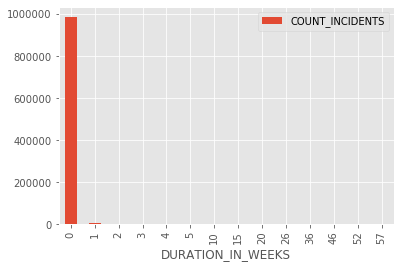

In [33]:
df.set_index("DURATION_IN_WEEKS").plot.bar();

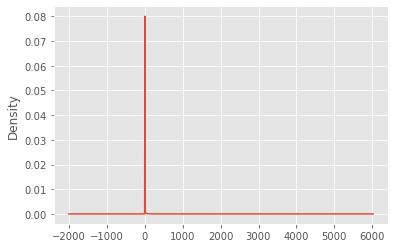

In [34]:
df = pd.read_sql_query("SELECT (CONT_DATE-DISCOVERY_DATE) AS DURATION FROM Fires;", conn)
df["DURATION"].plot.kde();

In [35]:
df = pd.read_sql_query("SELECT COUNT(OBJECTID) FROM Fires WHERE FIRE_SIZE IS NULL;", conn)
df

,COUNT(OBJECTID)
0,0


In [36]:
df = pd.read_sql_query("SELECT COUNT(DISTINCT(OWNER_CODE)) FROM Fires;", conn)
df

,COUNT(DISTINCT(OWNER_CODE))
0,16


### Can we predict fire size 

In [37]:
def prepare_data(conn, columns, limit=None, geohash_precision=None, apply_log=None):
    """
    Prepare the data to be ready to train. Impute values to get rid of missing values and 
    preprocess categorical values.
    
    Arguments:
        conn: SQLite connection (sqlite3) to the database.
        columns: Columns in SQL-syntax, which should be queried. Note, that you can also 
            combine columns, e. g. `(A-B) AS C`. Furthermore, a `VARCHAR`-datatype indicates 
            a categorical feature, while numbers are seen as numerical features.
        limit: Limit the amount of the queried data.
        apply_log: List of columnnames, for which a logarithm should be applied.
    Returns:
        X: Features / explanatory matrix 
        y: Response vector
    """
    
    if not "FIRE_SIZE" in columns:
        columns.append("FIRE_SIZE")
    
    columns_sql_string = ",".join(columns)
    
    limit_sql_string = ""
    if limit is not None:
        limit_sql_string = f"LIMIT {limit}"
        
    # In the current data version FIRE_SIZE is never NULL, however, since sqllite is dynamically typed, 
    # filtering does not hurt :). Same for minimum of DURATION_DAY.
    df = pd.read_sql_query(
        f"""
        SELECT {columns_sql_string} 
        FROM Fires JOIN NWCG_UnitIDActive_20170109 AS NWCG ON Fires.NWCG_REPORTING_UNIT_ID == NWCG.UnitId 
        WHERE FIRE_SIZE IS NOT NULL AND FIRE_SIZE > 0 AND DURATION_DAY > 0
        {limit_sql_string};
        """, 
        conn
    )
    
    if apply_log is not None:
        for column_name in apply_log:            
            df[column_name] = df[column_name].apply(np.log)
    
    X = df.drop(columns=["FIRE_SIZE"])
    y = df["FIRE_SIZE"]
    
    if geohash_precision is not None:
        create_geohash = lambda row: pgh.encode(row["LATITUDE"], row["LONGITUDE"], geohash_precision)
        X["GEOHASH"] = X[["LATITUDE", "LONGITUDE"]].apply(create_geohash, axis=1)
    
    # treat missing variables in numerical columns by imputing the mean
    # note, that int-typed columns can be categorical (e. g. STAT_CAUSE_CODE, but we take STAT_CAUSE_DESCR instead)
    X_numerical = X.select_dtypes(include=["float", "int"])
    fill_nan = lambda col: col.fillna(col.mean())
    X_numerical = X_numerical.apply(fill_nan)

    # prepare categorical columns
    X_categorical = X.select_dtypes(include=["object"])
    X_categorical = pd.get_dummies(X_categorical, dummy_na=False, drop_first=True)
    
    
    # Merge categorical and numerical
    X = pd.concat([X_numerical, X_categorical], axis=1)
    
    return X, y

columns = [
    "(CONT_DATE-DISCOVERY_DATE) AS DURATION_DAY",
    """
    (
      CONT_DATE - DISCOVERY_DATE + (
        ((CONT_TIME % 100)/60.0 + CONT_TIME / 100)/24
      ) - (
        ((DISCOVERY_TIME % 100)/60.0 + DISCOVERY_TIME / 100)/24
      )
    ) AS DURATION_COMBINED
    """, 
    """
    (
      ((DISCOVERY_TIME % 100)/60.0 + DISCOVERY_TIME / 100)/24 - 
      ((CONT_TIME % 100)/60.0 + CONT_TIME / 100)/24
    ) AS DURATION_DAY_HOURS
    """, 
    "LATITUDE", 
    "LONGITUDE", 
    "Fires.STATE", 
    "CAST(FIRE_YEAR AS VARCHAR) AS STR_FIRE_YEAR", 
    "CAST(DISCOVERY_DOY/20 AS VARCHAR) AS STR_DISCOVERY_DOY", 
    "DISCOVERY_DATE",
    "DISCOVERY_DOY",
    "CONT_DOY",
    "(366-DISCOVERY_DOY) AS DISCOVERY_DOY_INV",
    "CAST((366-DISCOVERY_DOY)/20 AS VARCHAR) AS STR_DISCOVERY_DOY_INV",
    "CAST(STAT_CAUSE_CODE AS VARCHAR) AS STR_STAT_CAUSE_CODE", 
    "WildlandRole",
    "Department",
    "Agency",
    "GeographicArea",
    "SOURCE_SYSTEM_TYPE",
    "SOURCE_SYSTEM",
    "Parent",
    "OWNER_CODE"
]

In [38]:
def fit_model(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.02, random_state=42)
    lm_model = LinearRegression(normalize=True)
    lm_model.fit(X_train, y_train)


    # Evaluate model performance r2_score

    # Predict 
    y_test_preds = lm_model.predict(X_test)
    y_train_preds = lm_model.predict(X_train)

    # Score
    test_score = r2_score(y_test, y_test_preds)
    train_score = r2_score(y_train, y_train_preds)

    return dict(test_score=test_score, train_score=train_score)

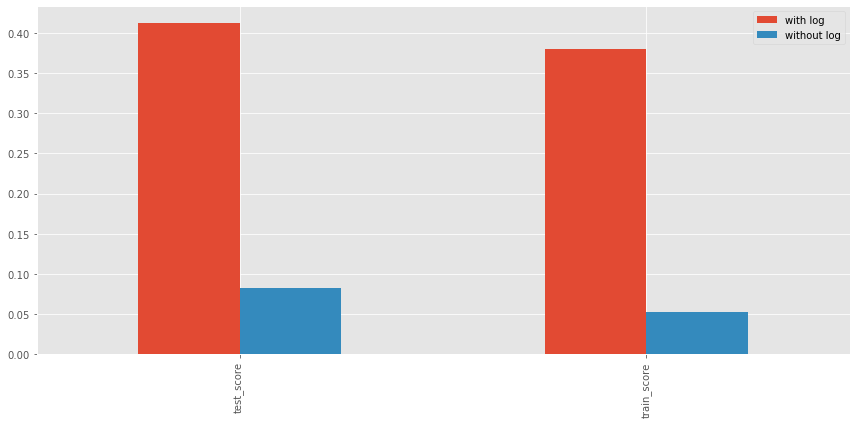

In [39]:
# without log
X, y = prepare_data(
    conn, 
    columns,
    limit=4e5,
    geohash_precision=2
)
scores_without_log = fit_model(X, y)

# with log
X_log, y_log = prepare_data(
    conn, 
    columns + [ 
        """
        (
          CONT_DATE - DISCOVERY_DATE + (
            ((CONT_TIME % 100)/60.0 + CONT_TIME / 100)/24
          ) - (
            ((DISCOVERY_TIME % 100)/60.0 + DISCOVERY_TIME / 100)/24
          )
        ) AS DURATION_COMBINED_LOG
        """
    ],
    limit=4e5,
    geohash_precision=2,
    apply_log=["FIRE_SIZE", "DURATION_COMBINED_LOG"]
)

scores_with_log = fit_model(X_log, y_log)

df = pd.DataFrame.from_records([scores_with_log, scores_without_log], index=["with log", "without log"])
df.T.plot.bar(**plot_options);

plt.tight_layout()
plt.savefig("figures/comparision_with_without_log.png")

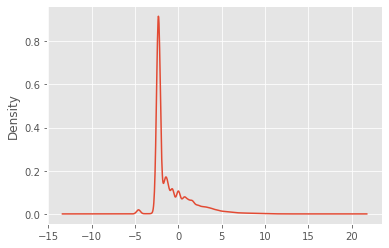

In [40]:
df = pd.read_sql_query(f"""
SELECT FIRE_SIZE FROM Fires LIMIT {1e5};
""", conn)
df["FIRE_SIZE"].apply(np.log).plot.kde();

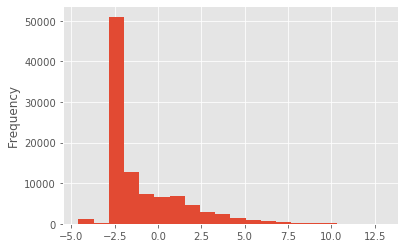

In [41]:
df["FIRE_SIZE"].apply(np.log).plot.hist(bins=20);

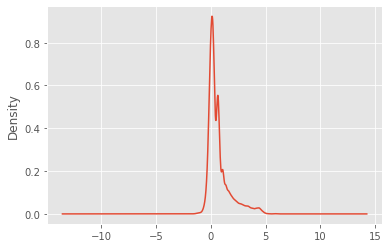

In [42]:
df = pd.read_sql_query(f"""
SELECT 
    (CONT_DATE-DISCOVERY_DATE + ((DISCOVERY_TIME % 100)/60.0 + DISCOVERY_TIME / 100)/24 - ((CONT_TIME % 100)/60.0 + CONT_TIME / 100)/24) AS DURATION FROM Fires WHERE DURATION > 0 LIMIT {1e5};
""", conn)
df["DURATION"].apply(np.log).plot.kde();

In [43]:
df["DURATION"]

0          5.083333
1          5.166667
2          1.083333
3          1.166667
4          1.000000
            ...    
99995      1.229167
99996      1.989583
99997    104.520833
99998      2.520833
99999     10.583333
Name: DURATION, Length: 100000, dtype: float64

In [44]:
df = pd.read_sql_query(f"""
SELECT (CONT_DATE-DISCOVERY_DATE) AS DURATION, 
(CONT_TIME-DISCOVERY_TIME) AS DURATION_DAY 
FROM Fires WHERE DURATION = 0 LIMIT {1e5};
""", conn)
df

,DURATION,DURATION_DAY
0,0.0,430.0
1,0.0,685.0
2,0.0,103.0
3,0.0,300.0
4,0.0,500.0
...,...,...
99995,0.0,700.0
99996,0.0,239.0
99997,0.0,700.0
99998,0.0,870.0


In [45]:
df = pd.read_sql_query(f"""
SELECT CONT_TIME % 100 AS CONT_TIME_MIN, 
  CONT_TIME / 100 AS CONT_TIME_HOUR, 
  ((CONT_TIME % 100)/60.0 + CONT_TIME / 100)/24 AS CONT_TIME_IN_DAYS,
  ((DISCOVERY_TIME % 100)/60.0 + DISCOVERY_TIME / 100)/24 - ((CONT_TIME % 100)/60.0 + CONT_TIME / 100)/24 AS DURATION_IN_DAYS,
  DISCOVERY_TIME FROM Fires LIMIT {15};
""", conn)
df

,CONT_TIME_MIN,CONT_TIME_HOUR,CONT_TIME_IN_DAYS,DURATION_IN_DAYS,DISCOVERY_TIME
0,30,17,0.729167,-0.187500,1300
1,30,15,0.645833,-0.281250,0845
2,24,20,0.850000,-0.043750,1921
3,0,14,0.583333,0.083333,1600
4,0,12,0.500000,0.166667,1600
5,0,16,0.666667,0.083333,1800
6,0,14,0.583333,0.166667,1800
7,0,16,0.666667,-0.125000,1300
8,0,17,0.708333,-0.208333,1200
9,0,18,0.750000,0.000000,1800


In [46]:
df = pd.read_sql_query(f"""
SELECT CONT_TIME % 100 AS CONT_TIME_MIN, 
  CONT_TIME / 100 AS CONT_TIME_HOUR, 
  ((CONT_TIME % 100)/60.0 + CONT_TIME / 100)/24 AS CONT_TIME_IN_DAYS, 
  ((DISCOVERY_TIME % 100)/60.0 + DISCOVERY_TIME / 100)/24 AS DISCOVERY_TIME_IN_DAYS,
  ((((CONT_TIME % 100)/60.0 + CONT_TIME / 100)/24) - (((DISCOVERY_TIME % 100)/60.0 + DISCOVERY_TIME / 100)/24)) AS DURATION_IN_DAYS,
  (CONT_DATE-DISCOVERY_DATE) AS DURATION, 
  (CONT_DATE-DISCOVERY_DATE+(((CONT_TIME % 100)/60.0 + CONT_TIME / 100)/24) - (((DISCOVERY_TIME % 100)/60.0 + DISCOVERY_TIME / 100)/24)) AS DURATION_COMBINED,
  DISCOVERY_TIME FROM Fires 
  WHERE DURATION_COMBINED < 0  
  LIMIT {15};
""", conn)
df

,CONT_TIME_MIN,CONT_TIME_HOUR,CONT_TIME_IN_DAYS,DISCOVERY_TIME_IN_DAYS,DURATION_IN_DAYS,DURATION,DURATION_COMBINED,DISCOVERY_TIME


In [47]:
df = pd.read_sql_query(f"""
SELECT 
        (
          ((DISCOVERY_TIME % 100)/60.0 + DISCOVERY_TIME / 100)/24 - 
          ((CONT_TIME % 100)/60.0 + CONT_TIME / 100)/24
        ) AS DURATION_DAY_HOURS
        FROM Fires LIMIT {15};
""", conn)
df

,DURATION_DAY_HOURS
0,-0.187500
1,-0.281250
2,-0.043750
3,0.083333
4,0.166667
5,0.083333
6,0.166667
7,-0.125000
8,-0.208333
9,0.000000


In [48]:
df = pd.read_sql_query("""
SELECT FIRE_SIZE FROM Fires JOIN NWCG_UnitIDActive_20170109 AS NWCG ON Fires.NWCG_REPORTING_UNIT_ID == NWCG.UnitId LIMIT 10;
""", conn)
df

,FIRE_SIZE
0,0.10
1,0.25
2,0.10
3,0.10
4,0.10
5,0.10
6,0.10
7,0.80
8,1.00
9,0.10


In [49]:
cursor.close()
conn.close()